# Set up


In [1]:
import matplotlib.pyplot as plt
import timm
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from torchvision.models import ResNet101_Weights, resnet101

from models.resnet import ResNet101

/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CLASSES = [
    "beauty_products",
    "electronics",
    "fashion",
    "fitness_equipments",
    "furniture",
    "home_appliances",
    "kitchenware",
    "musical_instruments",
    "study_things",
    "toys",
]

## ViT


In [3]:
def itest_ViT(weights_path, image):
    res = ""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = timm.create_model("vit_base_patch16_224.augreg_in21k")
    model.head = torch.nn.Linear(model.head.in_features, len(CLASSES))
    model = model.to(device).eval()

    weights = torch.load(weights_path, map_location=device, weights_only=True)
    model.load_state_dict(weights)

    image = Image.open(image)
    preprocess = transforms.Compose(
        [
            transforms.Resize((224, 224), antialias=True),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    batch = preprocess(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(batch)

    probs = torch.nn.functional.softmax(output[0], dim=0)
    for idx, prob in enumerate(probs):
        res += f"{CLASSES[idx]}: {prob * 100:.2f}%\n"

    res += f"\nPrediction: {CLASSES[probs.argmax()]}"
    res += f"\nTrue Label: {image.filename.split('/')[-2]}"

    plt.figure(figsize=(8, 4))
    plt.axis("off")
    plt.title(res, loc="left", x=-1.2, y=0)
    plt.imshow(image)

## ResNet-101


In [5]:
def itest_ResNet(weights_path, image):
    res = ""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ResNet101(num_classes=len(CLASSES))
    model = model.to(device).eval()

    weights = torch.load(weights_path, map_location=device, weights_only=True)
    model.load_state_dict(weights)

    image = Image.open(image)
    preprocess = transforms.Compose(
        [
            transforms.Resize((224, 224), antialias=True),
            transforms.ToTensor(),
            transforms.Normalize([0.7037, 0.6818, 0.6685], [0.2739, 0.2798, 0.2861]),
        ]
    )
    batch = preprocess(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(batch)

    probs = torch.nn.functional.softmax(output[0], dim=0)
    for idx, prob in enumerate(probs):
        res += f"{CLASSES[idx]}: {prob * 100:.2f}%\n"

    res += f"\nPrediction: {CLASSES[probs.argmax()]}"
    res += f"\nTrue Label: {image.filename.split('/')[-2]}"

    plt.figure(figsize=(8, 4))
    plt.axis("off")
    plt.title(res, loc="left", x=-1.2, y=0)
    plt.imshow(image)

## ResNet-101 (fine-tuned)


In [6]:
def itest_ResNet_tuning(weights_path, image):
    res = ""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = resnet101(weights=ResNet101_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, len(CLASSES))
    model = model.to(device).eval()

    weights = torch.load(weights_path, map_location=device, weights_only=True)
    model.load_state_dict(weights["model"])

    image = Image.open(image)
    preprocess = transforms.Compose(
        [
            transforms.Resize((224, 224), antialias=True),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    batch = preprocess(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(batch)

    probs = torch.nn.functional.softmax(output[0], dim=0)
    for idx, prob in enumerate(probs):
        res += f"{CLASSES[idx]}: {prob * 100:.2f}%\n"

    res += f"\nPrediction: {CLASSES[probs.argmax()]}"
    res += f"\nTrue Label: {image.filename.split('/')[-2]}"

    plt.figure(figsize=(8, 4))
    plt.axis("off")
    plt.title(res, loc="left", x=-1.2, y=0)
    plt.imshow(image)

# Test


In [7]:
image = "/Users/noah/Documents/data/test/musical_instruments/21p6uk0u0PL.jpg"

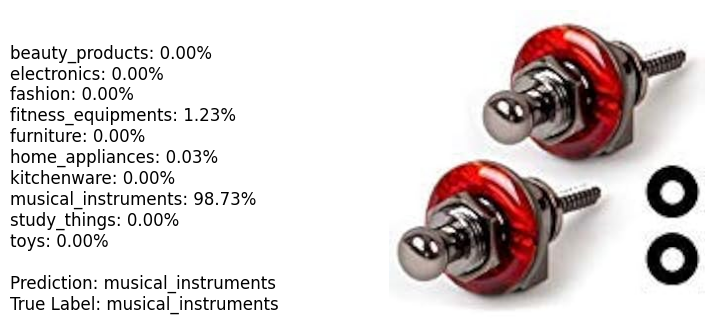

In [8]:
itest_ViT(
    weights_path="/Users/noah/Desktop/categories-classification/test/vit_weights.pth",
    image=image,
)

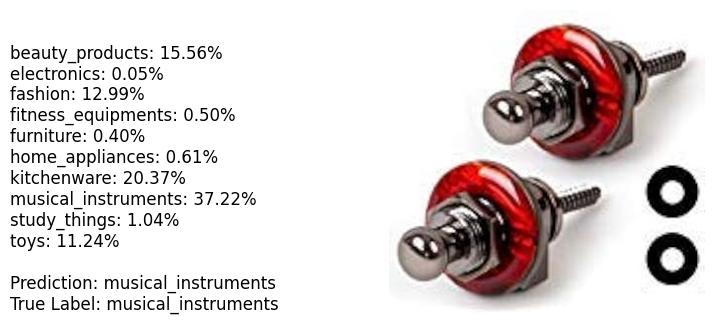

In [9]:
itest_ResNet(
    weights_path="/Users/noah/Desktop/categories-classification/test/resnet_weights.pth",
    image=image,
)

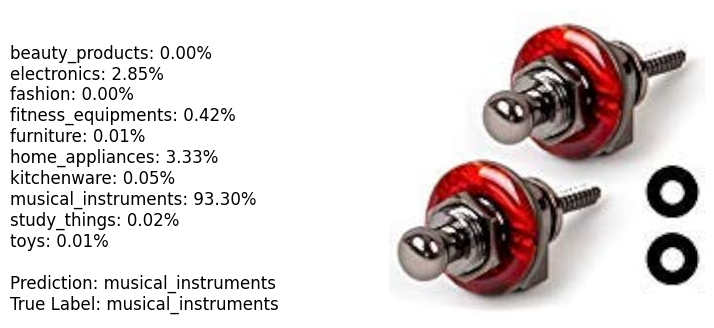

In [10]:
itest_ResNet_tuning(
    weights_path="/Users/noah/Desktop/categories-classification/test/resnet_tuning_weights.pth",
    image=image,
)